In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu


## constants and functions

In [2]:

PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

PATH_200_CLUS = '../data_out/cluster200.nc'

LA = 'lat'
LO = 'lon'
TI = 'time'
AG = 'age'
AT = 'AIRTRACER'
L = 'lab'
CM = 'tab20'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

COLS = [SA, MSA, IA]
LCOLS = [LSA, LMSA, LIA]

DATA_OUT = '../data_out'

COL = plt.get_cmap('Dark2')

DC = {
    SA  : COL(0),
    MSA : COL(1),
    IA  : COL(2),
    LSA : COL(0),
    LMSA: COL(1),
    LIA : COL(2),
}

In [3]:
df = pd.read_csv(PATH_TO_ST, index_col=0, parse_dates=True)

for l, c in zip(COLS, LCOLS):
    df[c] = np.log10(df[l])

# distributions


lets find what kind of dist. do we have. They seem to be log dists.

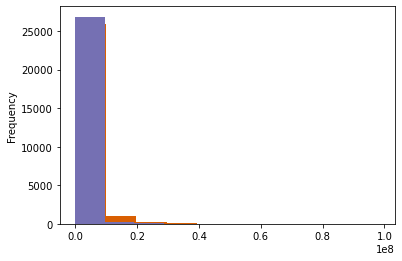

In [4]:
for c in COLS:
    df[c].plot.hist(color=DC[c])

Text(0.5, 0, 'log10')

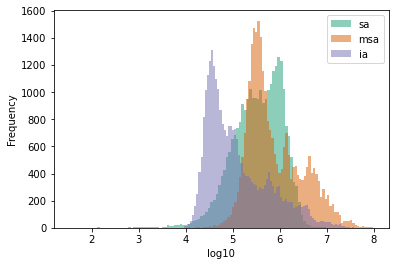

In [5]:
for c in COLS:
    np.log10(df[c]).plot.hist(alpha=.5, bins=100, label=c, color=DC[c])
ax = plt.gca()
ax.legend()
ax.set_xlabel('log10')

# timeseries of the trace gases

# open and merge flex 200 clusters

In [6]:
ds = xr.open_dataset(PATH_200_CLUS)

In [7]:
dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

q0, q1 = np.quantile(dsf.values.flatten(), [.01, .99])



# f, axs = plt.subplots(10, 20, sharex=True, sharey=True, figsize=(20, 20))
# axf = axs.flatten()

# for i, ax in zip(dsf.columns, axf):
#     ax.hist(np.log10(dsf[i] + q0), bins=np.linspace(np.log10(q0), np.log10(q1 + q0), 20))
#     ax.set_xlabel('')
#     ax.set_ylabel('')

In [8]:
dsfn = dsf / dsf.mean()

In [9]:
q0, q1 = dsfn.stack().quantile([.01, .99])

In [10]:
# f, axs = plt.subplots(10, 20, sharex=True, sharey=True, figsize=(20, 20))
# axf = axs.flatten()

# for i, ax in zip(dsfn.columns, axf):
#     ax.hist(dsfn[i], bins=np.linspace(q0, q1, 20))
#     ax.set_xlabel('')
#     ax.set_ylabel('')

In [11]:
df1 = df

In [12]:
df2 = df1.resample('3H').median()

In [13]:
dm = pd.merge(df2, dsf, left_index=True, right_index=True, how='inner', validate="1:1")

# Invers modeling elastic NET

In [14]:
# for PAR in [SA,MSA,IA]:
for PAR in [SA]:
    pred, cdf, y, yn, dp = rfu.elastic_net_reg(dsf, dm, PAR)
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
#     rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
#     rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
#     rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds,PAR)
#     rfu.plot_map(dd2)
#     rfu.plot_map_rect(dd2)

In [15]:
cdf.sort_values(ascending=False)

lab
199    52654256.0
196    20544958.0
181     8979031.0
132     3098593.5
180     2535800.5
          ...    
81            0.0
82            0.0
84            0.0
85            0.0
0             0.0
Length: 200, dtype: float32

In [16]:
import funs as fu

In [17]:
d5 = fu.get_bounds(LA, ds[AT])
d6 = fu.get_bounds(LO, d5)

df = d6[L].to_dataframe()

df1 = df.loc[:, ~df.columns.duplicated()]

G = 'geometry'

In [18]:
df1[G] = df.apply(fu.get_pol, axis=1)

In [19]:
import geopandas
dg = geopandas.GeoDataFrame(df1).reset_index()

dg1 = dg[[L, G]].dissolve(by=L)

In [20]:
cdf.name = 'infl'

In [21]:
df2 = pd.merge(dg1,cdf,left_index=True,right_index=True)

In [58]:
df3 = df2.sort_values('infl',ascending=False).iloc[:20]

In [59]:
df3['infl']

lab
199    5.265426e+07
196    2.054496e+07
181    8.979031e+06
132    3.098594e+06
180    2.535800e+06
168    1.881621e+06
173    1.812176e+06
159    1.730788e+06
162    1.352591e+06
86     1.257938e+06
136    9.339772e+05
105    8.134232e+05
131    7.817694e+05
42     7.806414e+05
31     7.485286e+05
100    6.634729e+05
141    6.443596e+05
109    5.435959e+05
129    4.531878e+05
14     3.943123e+05
Name: infl, dtype: float32

In [60]:
dm1 = dm[df3.index]

In [140]:
dm2 = dm1/dm1.sum()
dm2 = (dm1 * df3['infl'])/100000

In [142]:
cmap = plt.get_cmap('tab20')

In [143]:
co = dm2.columns

In [147]:
q1,q2=dm2.stack().quantile([.001,.999])

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


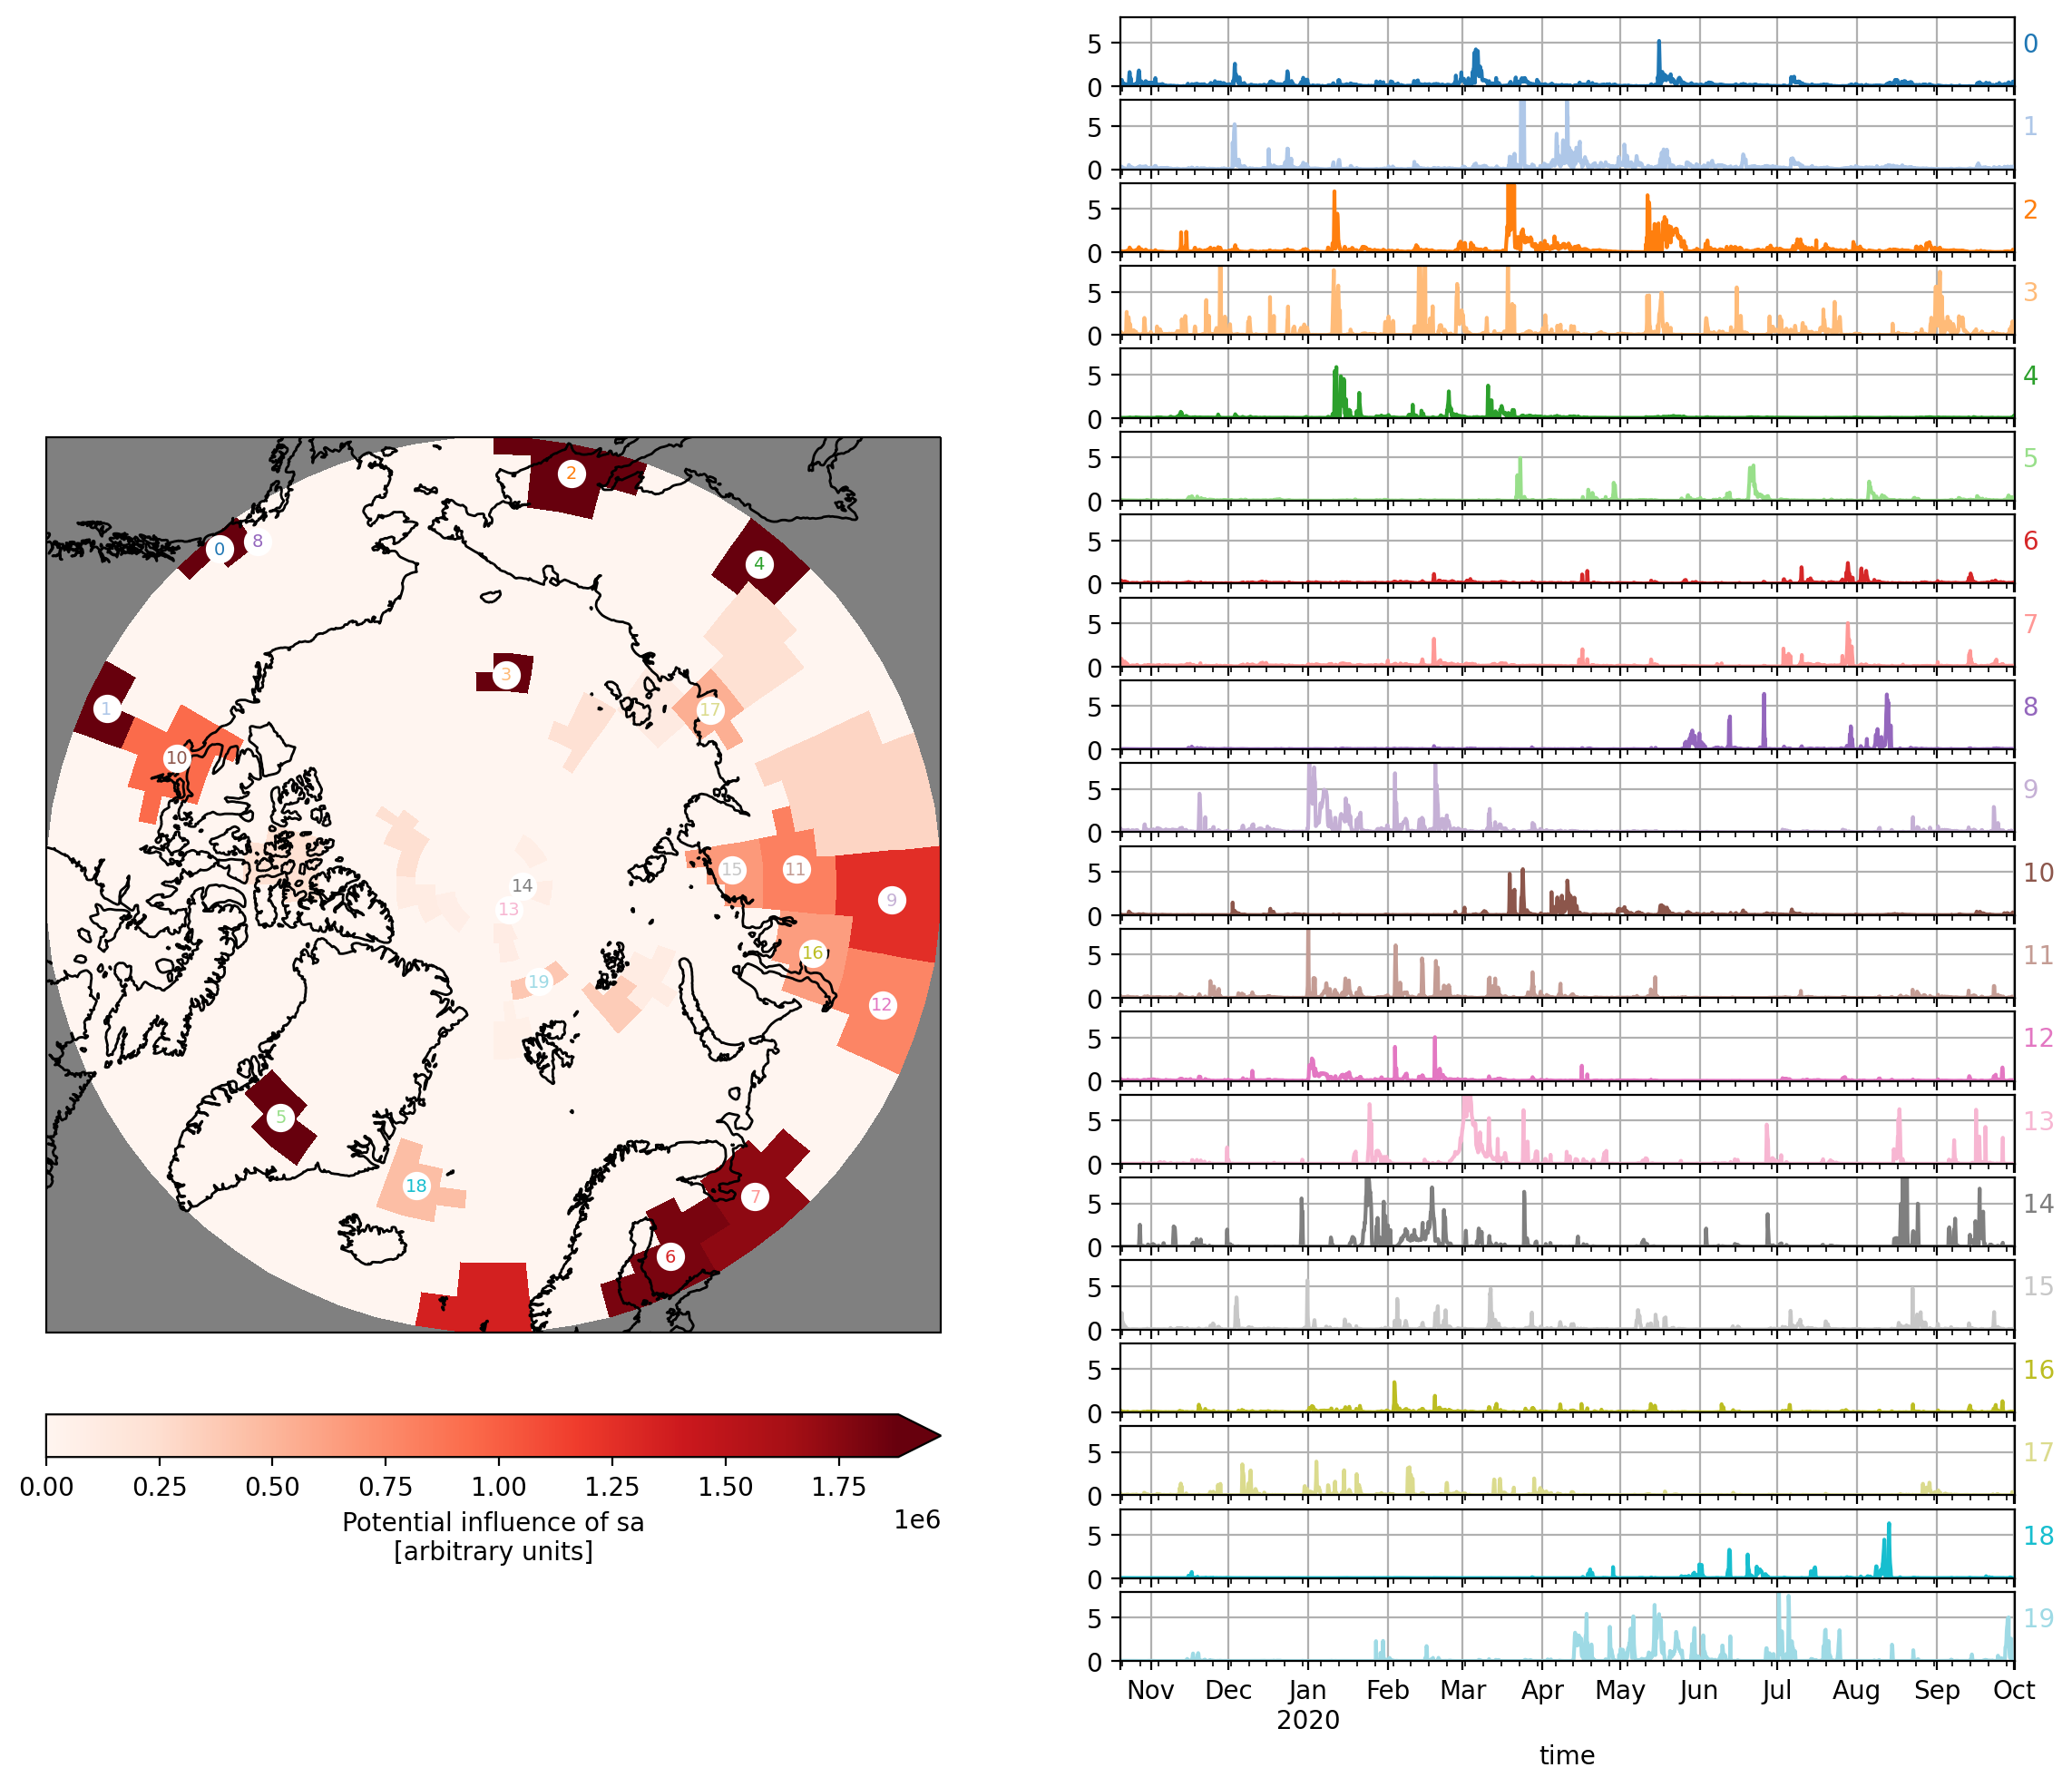

In [148]:
lco = len(co)

f = plt.figure(constrained_layout=True,figsize=(2*7,lco*.6),dpi=200)

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(lco,2)




# f,axs=plt.subplots(lco,dpi=200,sharex=True,sharey=True,figsize=(7,lco*.6))


ax0 = None
for i,c in enumerate(co):
    ax = f.add_subplot(gs[i, 1],sharex=ax0)
    if i == 0: ax0 = ax
    (dm2[c]).plot(c=cmap(i),ax=ax)
    ax.text(1,.5,f' {i}',transform=ax.transAxes,c=cmap(i))
    ax.grid()
    ax.set_ylim(0,q2*1.1)
# ax=plt.gca()
# ax.set_yscale('log')
# ax.set_ylim(q1,q2)
# ax.legend(bbox_to_anchor=(1,1))


import cartopy.crs as ccrs
ax = f.add_subplot(gs[:,0],projection=ccrs.Orthographic(0, 90), facecolor="gray")
rfu.plot_map(dd2,ax=ax)
# ax=plt.gca()
for i,c in enumerate(co):
    p =df3.centroid[c]
    ax.scatter( p.x,p.y,transform=ccrs.PlateCarree(),c='w',s=105,alpha=1,zorder=19)
    ax.text( p.x,p.y,i,transform=ccrs.PlateCarree(),c=cmap(i),va='center',ha='center',fontsize=7,zorder = 20)



In [150]:
#convert to mrakdown
!jupyter-nbconvert --to markdown z030_inverse_modeling_time_series.ipynb

[NbConvertApp] Converting notebook z030_inverse_modeling_time_series.ipynb to markdown
[NbConvertApp] Support files will be in z030_inverse_modeling_time_series_files/
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Writing 6925 bytes to z030_inverse_modeling_time_series.md
